# Klasifikasi: Prediksi Kelulusan (Student Pass Prediction)

Notebook ini dibuat sebagai contoh lengkap tugas klasifikasi untuk memprediksi apakah seorang mahasiswa **lulus** (pass) atau **tidak lulus** (fail).
Langkah-langkah yang dilakukan:
1. Membuat dataset sintetis (fitur relevan untuk prediksi kelulusan).
2. Exploratory Data Analysis (EDA) dan preprocessing.
3. Melatih minimal dua algoritma klasifikasi: Logistic Regression, Decision Tree, K-Nearest Neighbors.
4. Mengevaluasi model menggunakan confusion matrix, accuracy, precision, recall, F1-score, dan ROC curve.
5. Membandingkan hasil dan menarik kesimpulan.

Semua kode dapat dijalankan sel demi sel di notebook ini.


In [1]:
# Setup: import library dan set random seed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import seaborn as sns

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [2]:
# 1) Membuat dataset sintetis
# Fitur: hours_study (jam/minggu), attendance (persen), prev_grade (0-100), socioeconomic (0=low,1=mid,2=high), extracurricular (0/1)
n = 1000

hours_study = np.clip(np.random.normal(10, 4, n), 0, 40)
attendance = np.clip(np.random.normal(80, 10, n), 40, 100)
prev_grade = np.clip(np.random.normal(65, 15, n), 0, 100)
socio = np.random.choice([0,1,2], size=n, p=[0.3,0.5,0.2])
extra = np.random.binomial(1, 0.4, n)

# Probabilitas lulus (logit-like)
logit = -6 + 0.25*hours_study + 0.05*attendance + 0.03*prev_grade + 0.6*socio + 0.4*extra
prob_pass = 1 / (1 + np.exp(-logit))
passed = (np.random.rand(n) < prob_pass).astype(int)

df = pd.DataFrame({
    'hours_study': hours_study,
    'attendance': attendance,
    'prev_grade': prev_grade,
    'socioeconomic': socio,
    'extracurricular': extra,
    'passed': passed
})

df['passed_label'] = df['passed'].map({0:'fail',1:'pass'})
df.head()


,hours_study,attendance,prev_grade,socioeconomic,extracurricular,passed,passed_label
0,11.986857,93.993554,54.872326,2,1,1,pass
1,9.446943,89.246337,62.832220,2,0,1,pass
2,12.590754,80.596304,53.113701,0,1,1,pass
3,16.092119,73.530632,60.380577,2,0,1,pass
4,9.063387,86.982233,36.595780,1,0,1,pass


Shape: (1000, 7)


,hours_study,attendance,prev_grade,socioeconomic,extracurricular,passed
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,10.082164,80.615388,65.012630,0.893000,0.397000,0.929000
std,3.903105,9.763787,14.539408,0.697164,0.489521,0.256953
min,0.000000,50.596114,19.707318,0.000000,0.000000,0.000000
25%,7.409639,73.937583,55.280006,0.000000,0.000000,1.000000
50%,10.101202,80.630771,64.996239,1.000000,0.000000,1.000000
75%,12.591776,87.288822,74.913730,1.000000,1.000000,1.000000
max,25.410926,100.000000,100.000000,2.000000,1.000000,1.000000



Distribusi kelas:
passed_label
pass    0.929
fail    0.071
Name: proportion, dtype: float64


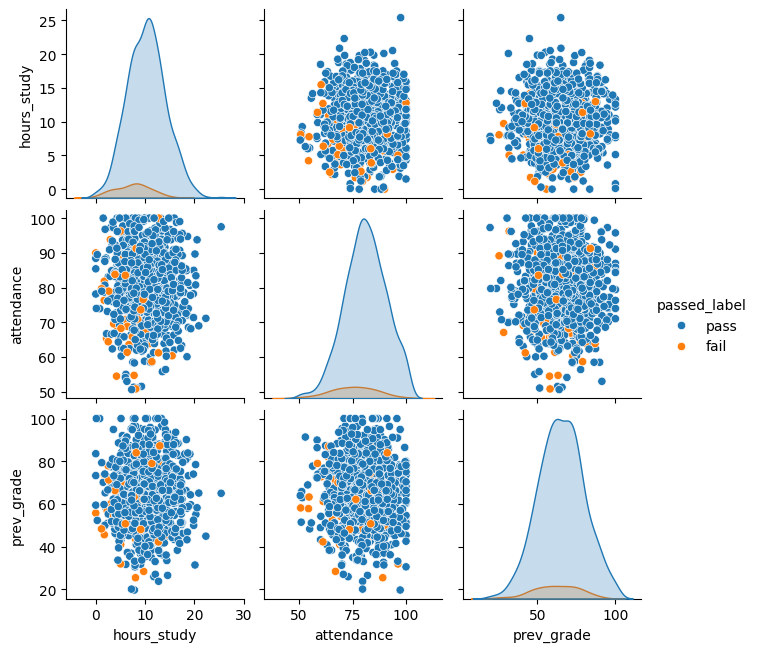

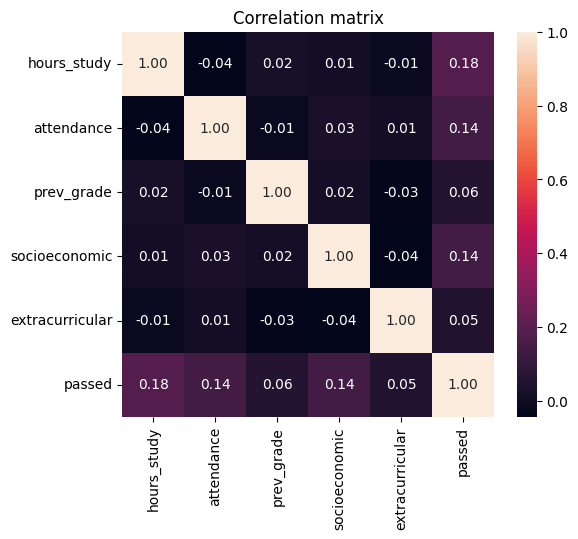

In [3]:
# 2) EDA singkat
print('Shape:', df.shape)
display(df.describe())

# Distribusi kelas
print('\nDistribusi kelas:')
print(df['passed_label'].value_counts(normalize=True))

# Pairplot (subset)
sns.pairplot(df[['hours_study','attendance','prev_grade','passed_label']], hue='passed_label', height=2.2)
plt.show()

# Korelasi
plt.figure(figsize=(6,5))
sns.heatmap(df[['hours_study','attendance','prev_grade','socioeconomic','extracurricular','passed']].corr(), annot=True, fmt='.2f')
plt.title('Correlation matrix')
plt.show()


In [4]:
# 3) Preprocessing
X = df.drop(columns=['passed','passed_label'])
y = df['passed']

# One-hot encode socio (categorical with 3 levels) - use pd.get_dummies
X = pd.get_dummies(X, columns=['socioeconomic'], prefix='socio', drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

# Scale numeric features for algorithms that benefit (KNN, Logistic)
num_cols = ['hours_study','attendance','prev_grade']
scaler = StandardScaler().fit(X_train[num_cols])
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[num_cols] = scaler.transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])


Train shape: (800, 6) Test shape: (200, 6)


In [5]:
# 4) Melatih beberapa model: Logistic Regression, Decision Tree, KNN
models = {
    'LogisticRegression': LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
    'DecisionTree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'KNN': KNeighborsClassifier()
}

# Optional: simple hyperparameter tuning for each
from sklearn.model_selection import GridSearchCV

param_grid = {
    'LogisticRegression': {'C':[0.01,0.1,1,10]},
    'DecisionTree': {'max_depth':[3,5,7, None], 'min_samples_leaf':[1,3,5]},
    'KNN': {'n_neighbors':[3,5,7,9]}
}

best_models = {}
for name, model in models.items():
    print('\nTuning', name)
    grid = GridSearchCV(model, param_grid[name], cv=5, scoring='f1', n_jobs=-1)
    if name == 'KNN' or name == 'LogisticRegression':
        grid.fit(X_train_scaled, y_train)
    else:
        grid.fit(X_train, y_train)
    print('Best params:', grid.best_params_)
    best_models[name] = grid.best_estimator_



Tuning LogisticRegression
Best params: {'C': 0.01}

Tuning DecisionTree
Best params: {'max_depth': 3, 'min_samples_leaf': 1}

Tuning KNN
Best params: {'n_neighbors': 7}



==== LogisticRegression ====
Confusion matrix:
 [[  0  14]
 [  0 186]]

Classification report:
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        14
           1     0.9300    1.0000    0.9637       186

    accuracy                         0.9300       200
   macro avg     0.4650    0.5000    0.4819       200
weighted avg     0.8649    0.9300    0.8963       200



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beha

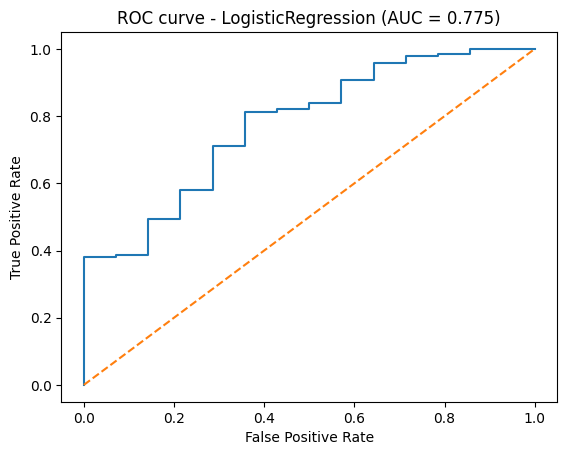


==== DecisionTree ====
Confusion matrix:
 [[  1  13]
 [  3 183]]

Classification report:
               precision    recall  f1-score   support

           0     0.2500    0.0714    0.1111        14
           1     0.9337    0.9839    0.9581       186

    accuracy                         0.9200       200
   macro avg     0.5918    0.5276    0.5346       200
weighted avg     0.8858    0.9200    0.8988       200



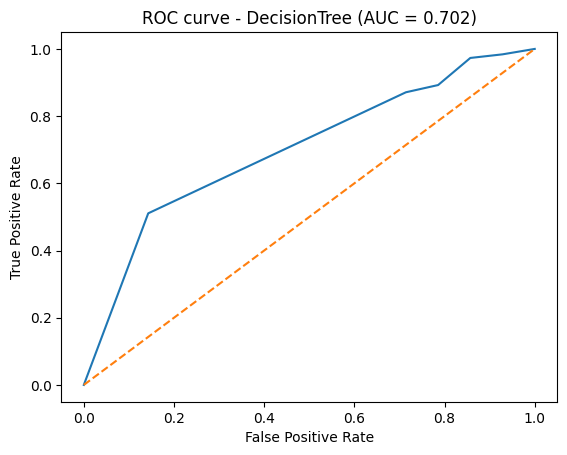


==== KNN ====
Confusion matrix:
 [[  2  12]
 [  0 186]]

Classification report:
               precision    recall  f1-score   support

           0     1.0000    0.1429    0.2500        14
           1     0.9394    1.0000    0.9688       186

    accuracy                         0.9400       200
   macro avg     0.9697    0.5714    0.6094       200
weighted avg     0.9436    0.9400    0.9184       200



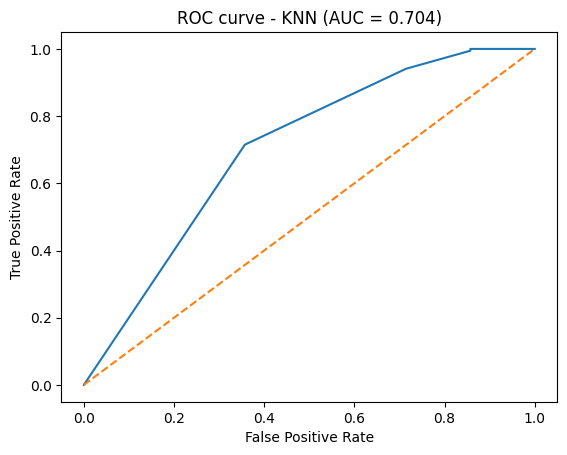

,accuracy,precision,recall,f1,roc_auc
model,,,,,
LogisticRegression,0.93,0.930000,1.000000,0.963731,0.775346
DecisionTree,0.92,0.933673,0.983871,0.958115,0.701613
KNN,0.94,0.939394,1.000000,0.968750,0.704493


In [6]:
# 5) Evaluasi: confusion matrix, accuracy, precision, recall, f1, ROC
results = []

for name, model in best_models.items():
    print('\n====', name, '====')
    if name in ['LogisticRegression', 'KNN']:
        Xtr = X_train_scaled
        Xte = X_test_scaled
    else:
        Xtr = X_train
        Xte = X_test
    ypred = model.predict(Xte)
    yprob = None
    if hasattr(model, 'predict_proba'):
        yprob = model.predict_proba(Xte)[:,1]
    elif hasattr(model, 'decision_function'):
        yprob = model.decision_function(Xte)
    cm = confusion_matrix(y_test, ypred)
    print('Confusion matrix:\n', cm)
    print('\nClassification report:\n', classification_report(y_test, ypred, digits=4))
    acc = accuracy_score(y_test, ypred)
    prec = precision_score(y_test, ypred)
    rec = recall_score(y_test, ypred)
    f1 = f1_score(y_test, ypred)
    roc_auc = None
    if yprob is not None:
        fpr, tpr, _ = roc_curve(y_test, yprob)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr)
        plt.plot([0,1],[0,1],'--')
        plt.title(f'ROC curve - {name} (AUC = {roc_auc:.3f})')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
    results.append({'model':name, 'accuracy':acc, 'precision':prec, 'recall':rec, 'f1':f1, 'roc_auc':roc_auc})

results_df = pd.DataFrame(results).set_index('model')
display(results_df)


In [7]:
# 6) Kesimpulan singkat
print('Hasil evaluasi (lihat tabel di atas).')
print('Catatan:')
print('- Bandingkan metrik F1 dan AUC untuk memilih model yang seimbang antara precision dan recall.')
print('- Decision Tree mudah diinterpretasikan (lihat visualisasi jika ingin).')
print('- Logistic Regression + scaling sering bekerja baik untuk data seperti ini.')


Hasil evaluasi (lihat tabel di atas).
Catatan:
- Bandingkan metrik F1 dan AUC untuk memilih model yang seimbang antara precision dan recall.
- Decision Tree mudah diinterpretasikan (lihat visualisasi jika ingin).
- Logistic Regression + scaling sering bekerja baik untuk data seperti ini.
